In [385]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anime
from matplotlib.animation import FuncAnimation
import math

## Уравнение Бюргерса
Уравнение гиперболического типа, которое будем решать:

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = μ \frac{\partial^2 u}{\partial x^2}$,  $\mu \in [0,1]$ -- параметр вязкости

В области $x \in [-10, 10], t \in [0, T]$

С начальными условиями $ u(x, 0) = \begin{cases} u_1 = 1,&  x < x_0 \\ 
                            u_0 = 0, & x \geq x_0 
                           \end{cases} ,    x_0 = 0$
                           
 Краевые условия восстановим из точного решения $\displaystyle u_0 = \frac{1}{1 + g(x,t) exp(\frac{x-t}{2\mu})}$,  $\displaystyle g(x,t) = \frac{Erfc\left(\frac{-x}{\sqrt{4 \mu t}}\right)}{Erfc \left(\frac{x-t}{\sqrt{4\mu t}}\right)}$
                     

 Будем использовать при решении шаблоны:

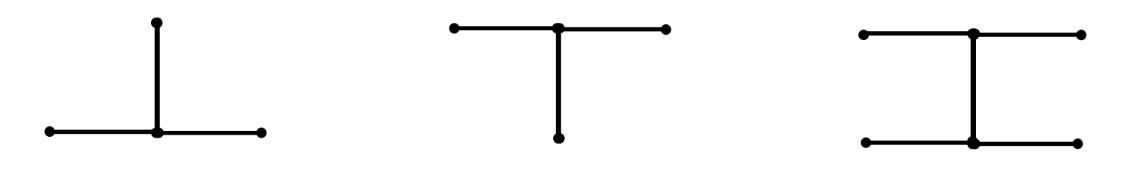

### 1. 
Выберем схему для первого шаблона:

$\displaystyle \frac{\hat{y}_m - y_m}{t} + y_m\frac{y_{m+1} - y_{m-1}}{2 h} = \mu \frac{y_{m+1} + y_{m-1} - 2 y_m}{h^2}$

Порядок схемы $O(\tau, h^2)$, спектральный признак с методом замороженных коэффициентов даёт условие устойчивости $\displaystyle (1 - \frac{4 \mu \tau }{h^2}sin(\alpha / 2)^2)^2 + (\frac{С \tau}{h} sin\alpha)^2 < 1$ $\forall \alpha$, где $C = \max |u(x,t)| = 1$. Условие устойчивости я проверяла численно для всех наборов $\tau, h, \mu$.

### 2. 
Для второго шаблона:

$\displaystyle \frac{\hat{y}_m - y_m}{\tau} + y_m\frac{\hat{y}_{m+1} - \hat{y}_{m-1}}{2 h} = \mu \frac{\hat{y}_{m+1} + \hat{y}_{m-1} - 2 \hat{y}_m}{h^2}$

Порядок схемы $O(\tau, h^2)$, схема безусловно устойчива



### 3.
На шеститочечном шаблоне:

$\displaystyle \frac{\hat{y}_m - y_m}{\tau} + y_m\frac{\hat{y}_{m+1} - \hat{y}_{m-1}}{4 h} + y_m\frac{y_{m+1} - y_{m-1}}{4 h}= \mu \frac{\hat{y}_{m+1} + \hat{y}_{m-1} - 2 \hat{y}_m}{2 h^2} + \mu \frac{y_{m+1} + y_{m-1} - 2 y_m}{2 h^2}$

Порядок схемы $O(\tau, h^2)$, схема безусловно устойчива

In [477]:
def real_sol(t, x, mu):
    u = np.empty([len(t), len(x)], dtype='double')
        
    for i in range(len(t)):
        for j in range(len(x)):            
                lim1 = -x[j]/np.sqrt(4*mu*t[i])
                lim2 = (x[j] - t[i])/ np.sqrt(4*mu*t[i])
                if math.erfc(lim2) == 0:
                    u[i][j] = 0
                else:
                    g = math.erfc(lim1)/math.erfc(lim2)
                    u[i][j] = 1/(1+ g*np.exp((x[j] - t[i]/2)/2/mu))   
    return u

In [482]:
def solve(tau, h, mu, scheme=1, T = 10, L = 10):
    
    N = int(T/tau)
    M = int(2*L/h)
    
    x = np.linspace(-L, L, M, dtype='double')
    t = np.linspace(1e-15, T, N, dtype='double')
    y = np.empty([N, M], dtype='double')
    
    y_real = real_sol(t, x, mu)
    
    for i in range(M):
        y[0][i] = y_real[0][i]
        
    for i in range(N):
        y[i][0] = y_real[i][0]
        y[i][M-1] = y_real[i][M-1]
        
    if scheme == 1:                            #первая схема
        for n in range(0, N-1):
            for m in range(1, M-1):
                y[n+1][m] = y[n][m] + tau*(mu/h**2 *(y[n][m+1] + y[n][m-1] - 2*y[n][m]) - y[n][m]*(y[n][m+1] - y[n][m-1])/(2*h))  
                
    elif scheme == 2:                          # вторая схема
        for n in range (1, N):
            A = np.zeros([M, M])
            b = np.zeros(M)

            for m in range(1, M-1):                 
                A[m][m] = 1/tau + 2*mu/h**2
                A[m][m-1] = - y[n-1][m]/ 2/h - mu/h**2
                A[m][m+1] = y[n-1][m]/2/h - mu/h**2

            A[0][0], A[-1][-1] = 1, 1 
        
            b[0] = y_real[n][0]
            b[M-1] = y_real[n][M-1]
            for m in range(1, M-1):
                b[m] = y[n-1][m]/tau
            sol = np.linalg.solve(A, b)
            y[n] = sol
            
    elif scheme == 3:                          # третья схема
        for n in range (1, N):
            A = np.zeros([M, M])
            b = np.zeros(M)

            for m in range(1, M-1):                 
                A[m][m] = 1/tau + mu/h**2
                A[m][m-1] = - y[n-1][m]/ 4/h - mu/2/h**2
                A[m][m+1] = y[n-1][m]/4/h - mu/2/h**2

            A[0][0], A[-1][-1] = 1, 1 
        
            b[0] = y_real[n][0]
            b[M-1] = y_real[n][M-1]
            for m in range(1, M-1):
                b[m] = y[n-1][m]/tau - y[n-1][m]*(y[n-1][m+1] - y[n-1][m-1])/4/h + mu*(y[n-1][m+1] + y[n-1][m-1]-2*y[n-1][m])/2/h**2
            sol = np.linalg.solve(A, b)
            y[n] = sol
            
    return t, x, y, y_real

In [397]:
def real_plot(n, t, x, y1, y2, y3, mu):
    plt.clf()
    plt.ylim([0, 1])
    plt.title(f"Точное решение при t = {t[n]:.2f}")
    plt.xlabel("x")
    plt.ylabel("u")
    
    plt.plot(x, y1[n], label='mu = ' + str(mu[0]))
    plt.plot(x, y2[n], label='mu = '  + str(mu[1]))
    plt.plot(x, y3[n], label='mu = '  + str(mu[2]))

    plt.legend(loc='lower left'	)
    plt.grid()
    
    return plt

In [396]:
def plot_n(n, t, x, y1, y2, y3, mu, scheme):
    plt.clf()
    plt.ylim([0, 1.1])
    plt.title(f"Решение схемой "+str(scheme)+f" при t = {t[n]:.2f}")
    plt.xlabel("x")
    plt.ylabel("u")
    
    plt.plot(x, y1[n], label='mu = ' + str(mu[0]))
    plt.plot(x, y2[n], label='mu = '  + str(mu[1]))
    plt.plot(x, y3[n], label='mu = '  + str(mu[2]))

#     plt.plot(x, y_real[n], label='точное решение', linestyle='dashed')
    plt.legend(loc='lower left'	)
    plt.grid()
    
    return plt

In [451]:
def scheme_compare_plot(n, t, x, y1, y2, y3, y_real, mu):
    plt.clf()
    plt.ylim([0, 1])
    plt.title(f"Сравнение решений разными схемами для $\mu$=" +str(mu)+f" при t = {t[n]:.2f}")
    plt.xlabel("x")
    plt.ylabel("u")
    
    plt.plot(x, y1[n], label='1')
    plt.plot(x, y2[n], label='2')
    plt.plot(x, y3[n], label='3')
    
    plt.plot(x, y_real[n], label='точное решение', linestyle='dashed')

    plt.legend(loc='lower left'	)
    plt.grid()
    
    return plt

In [504]:
def plot_h(n, t, x1, x2, x3, y1, y2, y3, y_real, mu, scheme):
    plt.clf()
    plt.ylim([0, 1.1])
    plt.title(f"Зависимость от h для схемы "+str(scheme)+f" для $\mu$=" +str(mu)+f" при t = {t[n]:.2f}")
    plt.xlabel("x")
    plt.ylabel("u")
    h = [1, 0.4, 0.1, 0.1]

    plt.plot(x1, y1[n], label='h = ' + str(h[0]))
    plt.plot(x2, y2[n], label='h = '  + str(h[1]))
    plt.plot(x3, y3[n], label='h = '  + str(h[2]))

    plt.plot(x3, y_real[n], label='точное решение', linestyle='dashed')
    plt.legend(loc='lower left'	)
    plt.grid()
    
    return plt

In [398]:
def animate(n):
    n = int(n / num_frames * len(t))
    plot_n(n, t, x, y1, y2, y3, mu, scheme)
    
def animate_real(n):
    n = int(n / num_frames * len(t))
    real_plot(n, t, x, y1, y2, y3, mu)

In [457]:
def animate_scheme_compare(n):
    n = int(n / num_frames * len(t))
    scheme_compare_plot(n, t, x, y1, y2, y3, y_real, mu)

def animate_h(n):
    n = int(n / num_frames * len(t))
    plot_h(n, t, x1, x2, x3, y1, y2, y3, y_real, mu, scheme)

Вид точного решения: распространяющаяся вправо с единичной скоростью волна, где $\mu$ определяет ширину фронта волны 

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in double_scalars
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


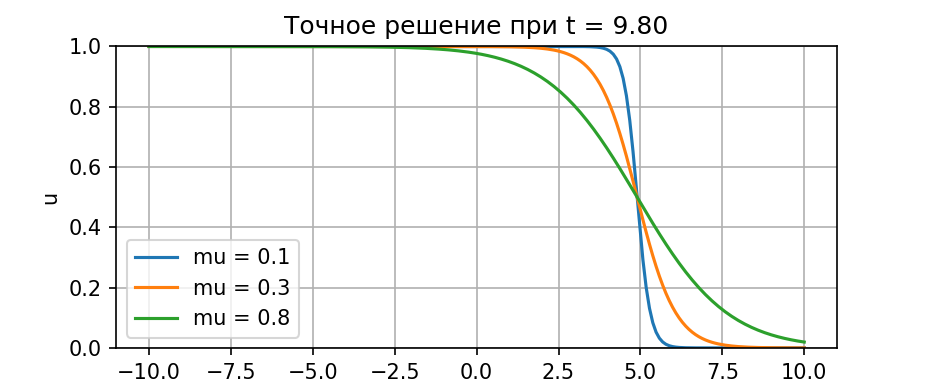

In [527]:
tau = 0.1
h = 0.1
mu = [0.1, 0.3, 0.8]

t,x, _, y1 = solve(tau, h ,mu[0])           #точное решение
_, _, _, y2 = solve(tau, h, mu[1])
_, _, _, y3 = solve(tau, h, mu[2])

%matplotlib notebook
num_frames = 40 
anim = anime.FuncAnimation(plt.figure(), animate_real, interval = 100, frames = num_frames, repeat = False)
plt.show()

Теперь визуализируем численные решения для того же набора параметров $\mu$ для каждой схемы. Можно видеть, что "центры" волн на высоте 0.5 распространяются с одинаковой скоростью, то есть не зависят от $\mu$.

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


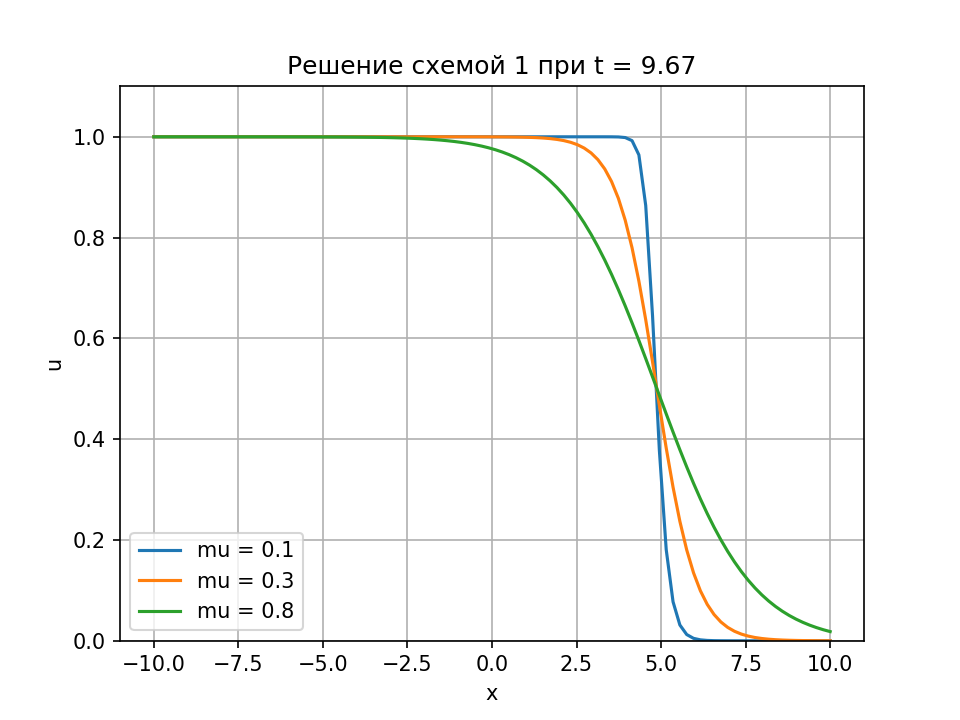

In [508]:
tau = 0.01
h = 0.2
mu = [0.1, 0.3, 0.8]

scheme = 1

t,x, y1, y_real = solve(tau, h ,mu[0], scheme)
_, _, y2, _ = solve(tau, h, mu[1], scheme)
_, _, y3, _ = solve(tau, h, mu[2], scheme)

%matplotlib notebook

num_frames = 30 

anim = anime.FuncAnimation(plt.figure(), animate, interval = 100, frames = num_frames, repeat = False)
plt.show()

 Сравним три схемы между собой для значения $\mu=0.5$ и параметров h = 0.8, $\tau$ = 0.1

<IPython.core.display.Javascript object>


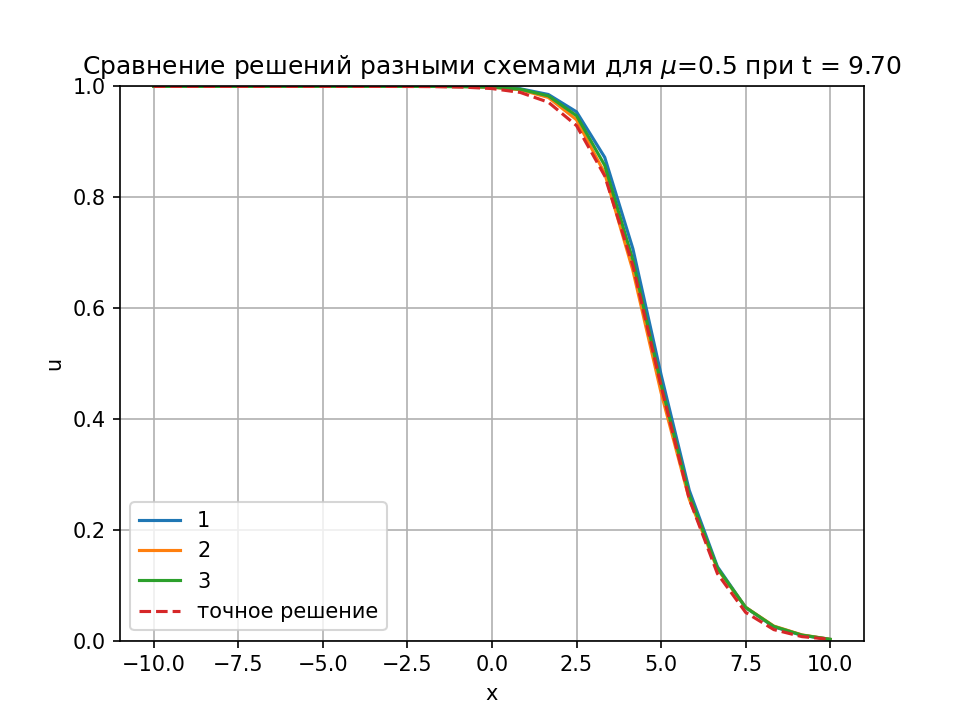

In [509]:
mu = 0.5
h = 0.8
tau = 0.1

t, x, y1, _ = solve(tau, h, mu, 1)
_, _, y2, _ = solve(tau, h, mu, 2)
_, _, y3, y_real = solve(tau, h, mu, 3)

%matplotlib notebook

num_frames = 30 

anim = anime.FuncAnimation(plt.figure(), animate_scheme_compare, interval = 100, frames = num_frames, repeat = False)
plt.show()

Как видно, все схемы аппроксимируют точное решение.

Выберем значение $\mu = 0.5$, при котором исследуем сходимость решения при измельчении h в последовательности [0.8, 0.4, 0.1] .

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


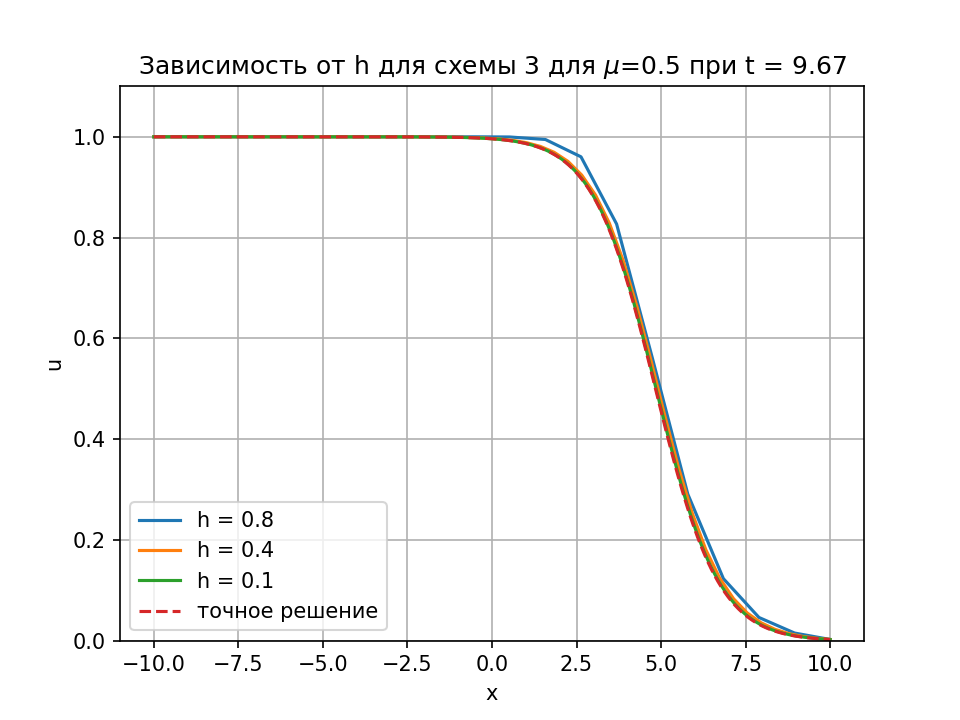

In [503]:
mu = 0.5

h = [1, 0.4, 0.1, 0.1]
tau = 5e-3

scheme = 3

t,x1, y1, _ = solve(tau, h[0], mu, scheme)
_, x2, y2, _ = solve(tau, h[1], mu, scheme)
_, x3, y3, y_real = solve(tau, h[2], mu, scheme)

%matplotlib notebook

num_frames = 30 

anim = anime.FuncAnimation(plt.figure(), animate_h, interval = 100, frames = num_frames, repeat = False)
plt.show()

Вычислим ошибку:

In [528]:
scheme = 1

mu = 0.5

h = [1, 0.4, 0.1]
tau = 5e-3

_,_, y1, y_real1 = solve(tau, h[0], mu, scheme)
_, _, y2, y_real2 = solve(tau, h[1], mu, scheme)
_, _, y3, y_real3 = solve(tau, h[2], mu, scheme)
# _, _, y4, y_real4 = solve(tau, h[3], mu, scheme)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


In [529]:
_,_, y21, _ = solve(tau, h[0], mu, 2)
_, _, y22, _ = solve(tau, h[1], mu, 2)
_, _, y23, _ = solve(tau, h[2], mu, 2)

_,_, y31, _ = solve(tau, h[0], mu, 3)
_, _, y32, _ = solve(tau, h[1], mu, 3)
_, _, y33, _ = solve(tau, h[2], mu, 3)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


In [514]:
def calc_err(a, b):
    err = np.empty_like(a)
    for i in range(len(a)):
        for j in range(len(a[0])):
            err[i][j] = np.abs(a[i][j] - b[i][j])
    return np.amax(err)

In [ ]:
      
max_err1 = [calc_err(y1, y_real1), calc_err(y2, y_real2), calc_err(y3, y_real3)]    
max_err2 = [calc_err(y21, y_real1), calc_err(y22, y_real2), calc_err(y23, y_real3)]        
max_err3 = [calc_err(y31, y_real1), calc_err(y32, y_real2), calc_err(y33, y_real3)]        

        

<IPython.core.display.Javascript object>


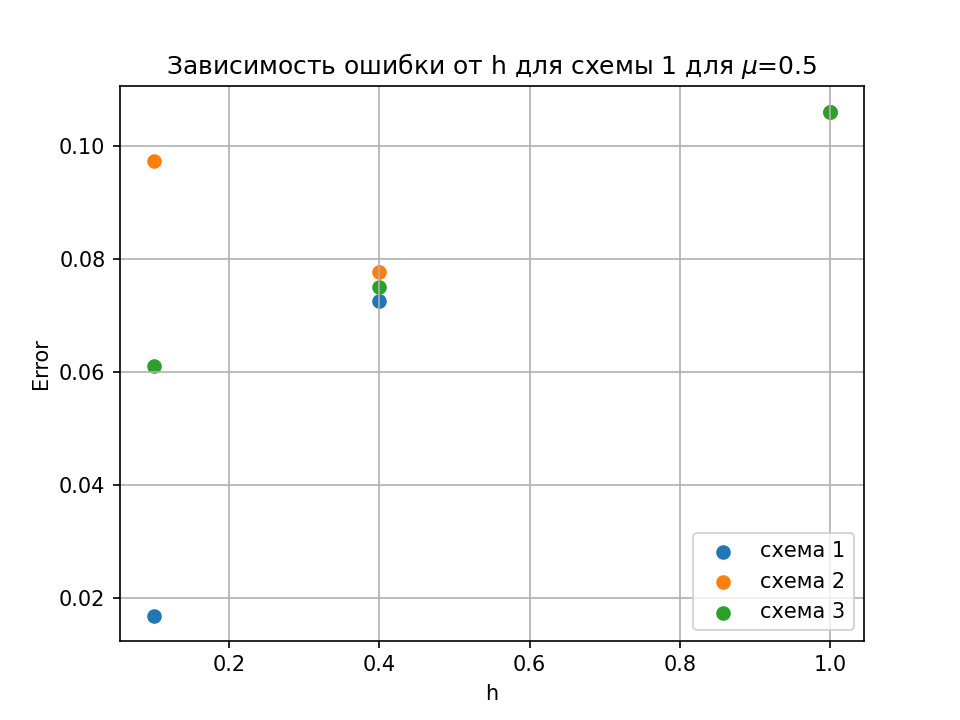

In [531]:
%matplotlib notebook
plt.clf()
plt.title(f"Зависимость ошибки от h для схемы "+str(scheme)+f" для $\mu$=" +str(mu))
plt.xlabel("h")
plt.ylabel("Error")
plt.scatter(h[:3], max_err1, label='схема 1')
plt.scatter(h[:3], max_err2, label='схема 2')
plt.scatter(h[:3], max_err3,label='схема 3')

plt.legend()
plt.grid()
plt.show()